In [38]:
import numpy as np  
import matplotlib.pyplot as plt  
import astropy.constants as c  
import astropy.units as u  

year  = (1*u.year).cgs.value
au    = c.au.cgs.value
M_jup = c.M_jup.cgs.value
M_sun = c.M_sun.cgs.value

from simple_slider import Widget
from simple_slider import kanagawa_profile
from simple_slider import get_surface_density
from simple_slider import get_disk_height

%matplotlib notebook

In [39]:
import simple_slider
import os

Select the number of planets

Choices: [1,3]

In [53]:
gl_n_planets = 1

In [54]:
if gl_n_planets==3:
    data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, 'data_3_planets')
elif gl_n_planets == 1:
    data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, 'data_1_planet')
else:
    print("please select valid directory")
r = (np.loadtxt(os.path.join(data_dir, 'radius.dat')))
sigma = np.loadtxt(os.path.join(data_dir, 'sigma_averaged.dat'), unpack=1)
time = np.loadtxt(os.path.join(data_dir, 'time.dat'))

Interpolate on a log grid

In [55]:
r_log = np.logspace(np.log10(20), np.log10(400), 500) * au
sigma_log = 10.**np.array([np.interp(np.log10(r_log), np.log10(r), np.log10(sig)) for sig in sigma.T]).T


Select the snapshot

In [56]:
t   = time.searchsorted(5 * 1e5 * year)
#t  = 0
sig = sigma_log[:, t]

Define the logp function: create a model based on the parameters and compare it to the data

In [57]:
from log_prob import logp, log_prior, log_prob, conv_params_model

In [58]:
ndim = 3 + 2 * gl_n_planets
p0 = conv_params_model(np.random.rand(10,ndim), r_log, gl_n_planets)
#print(p0)
print(log_prob(p0[1], r_log, sig, gl_n_planets,1))
log_prior(p0[0], r_log, gl_n_planets,1)
p0[:,3] = (60+np.random.rand(p0.shape[0]))*au
p0

-82142.81107210458


array([[ 2.49429931e-02,  7.06249177e+01, -1.75394277e+00,
         9.02163290e+14,  2.92979231e-04],
       [ 2.94793077e-03,  2.37343058e-01, -8.27579855e-01,
         8.98034054e+14,  4.34251323e-04],
       [ 2.65597968e-04,  2.23339309e+00, -1.61355771e+00,
         9.09576164e+14,  2.32700768e-03],
       [ 2.58936995e-04,  6.73252119e+00, -1.90321997e+00,
         9.11438776e+14,  5.29928244e-04],
       [ 6.12598777e-02,  2.07422588e+01, -1.41035231e+00,
         9.10573406e+14,  6.54334262e-04],
       [ 8.93095067e-04,  1.37444838e+01, -1.26017249e+00,
         8.98765143e+14,  1.18209681e-04],
       [ 2.24494639e-02,  2.96860725e-01, -1.31574239e+00,
         9.11856047e+14,  8.75881712e-04],
       [ 3.24429845e-04,  4.32015137e+00, -2.42528066e-01,
         9.11939221e+14,  3.69741595e-04],
       [ 4.75657209e-04,  1.50965704e-01, -9.25060275e-01,
         9.10143412e+14,  1.15281322e-03],
       [ 3.72384110e-04,  3.12181471e+01, -1.76083893e+00,
         9.04162623e+14

In [59]:
import emcee
from multiprocessing import Pool

nwalkers = 300
# need to input ndim as 3 + (2 * n_plantes) somewhere else
ndim = 3 + 2 * gl_n_planets
n_burnin = 400
n_steps = 700

pos = np.random.rand(nwalkers, ndim)
pos = conv_params_model(pos, r_log, gl_n_planets)
if gl_n_planets == 3:
    pos[:,3] = (55.+np.random.rand(pos.shape[0])*10)*au
    pos[:,5] = (95.+np.random.rand(pos.shape[0])*10)*au
    pos[:,7] = (155.+np.random.rand(pos.shape[0])*10)*au

masks = [conv_params_model(np.ones_like(pos[0]), r_log, gl_n_planets), conv_params_model(np.zeros_like(pos[0]), r_log, gl_n_planets)]
    
nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob,args=(r_log, sig, gl_n_planets, masks), pool=pool)
    state = sampler.run_mcmc(pos, n_burnin, progress=True)
        
    new_pos             = state.coords.copy()
    good_mask           = sampler.lnprobability[:, -1] > np.median(sampler.lnprobability[:, -1]) * 3
    good_indices        = np.where(good_mask)[0]
    new_good_indices    = np.random.choice(good_indices, size=(~good_mask).sum())
    new_pos[~good_mask] = new_pos[new_good_indices]

    sampler.reset()

    sampler.run_mcmc(new_pos, n_steps, progress=True)
 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:07<00:00, 92.42it/s]


In [60]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
#print(sampler.get_autocorr_time())

Mean acceptance fraction: 0.509


<IPython.core.display.Javascript object>


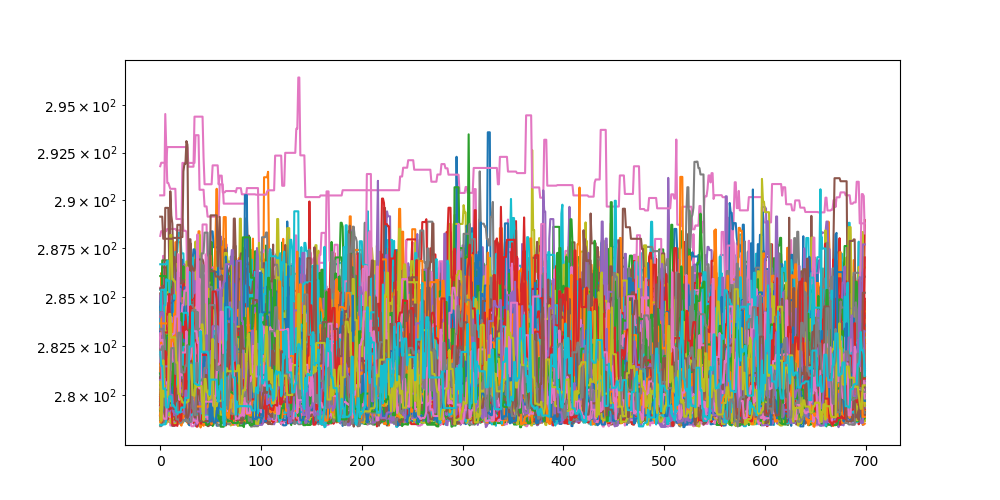

In [61]:
f, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(np.arange(sampler.lnprobability.shape[-1]), -sampler.lnprobability.T);

<IPython.core.display.Javascript object>


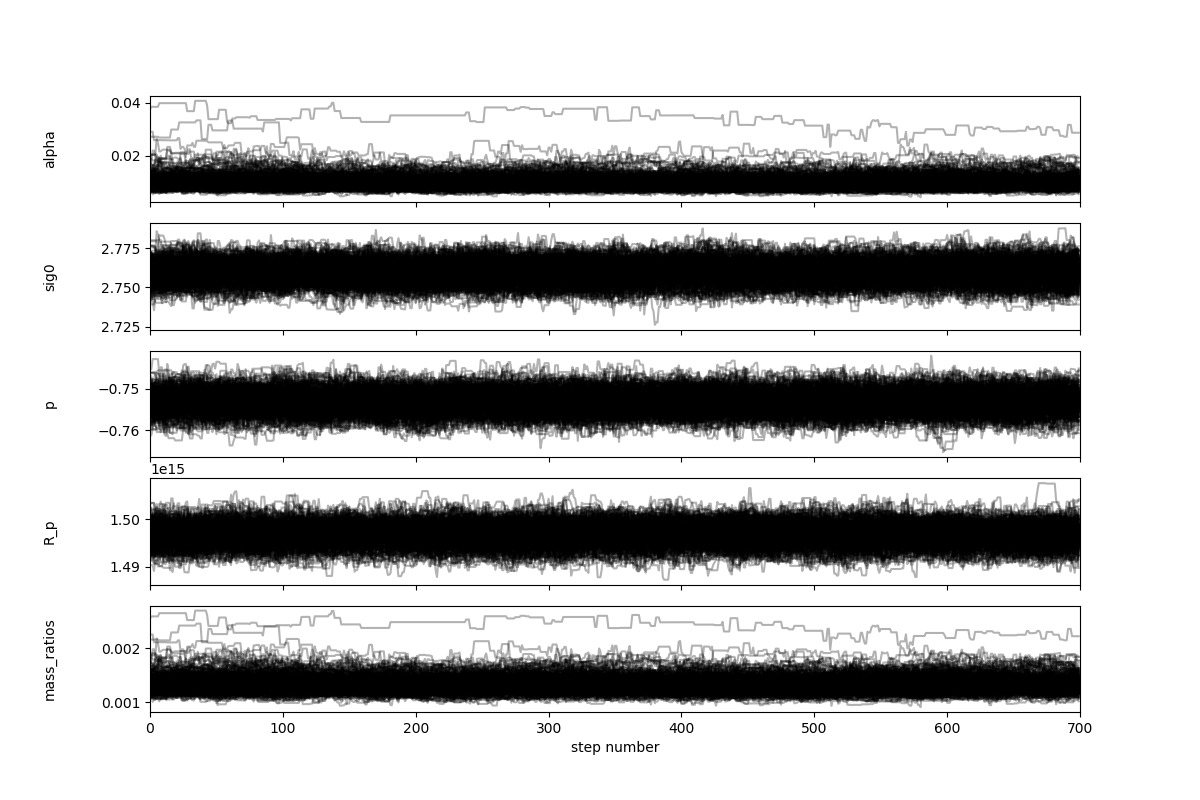

In [62]:
fig, axes = plt.subplots(ndim, figsize=(12, 8), sharex=True)
samples = sampler.get_chain()
labels = ["alpha", "sig0", "p", "R_p","mass_ratios", "R_p","mass_ratios", "R_p","mass_ratios"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [63]:
flat_samples = sampler.get_chain(discard=200, flat=True)
means = []
mcmc = []
for i in range(ndim):
    means += [np.mean(flat_samples[:,i])]
    mcmc += [np.percentile(flat_samples[:, i], 99)]
    
print("mean values: ", means)
print("50th percentiles: ", mcmc)

mean values:  [0.010155624691310209, 2.7596068613320495, -0.7531830348511488, 1496767542820381.8, 0.0013363335332439172]
50th percentiles:  [0.018524302600271186, 2.7757068760918076, -0.7469818817031435, 1501943169401901.5, 0.0018014244257533792]


(150000, 5)


<IPython.core.display.Javascript object>


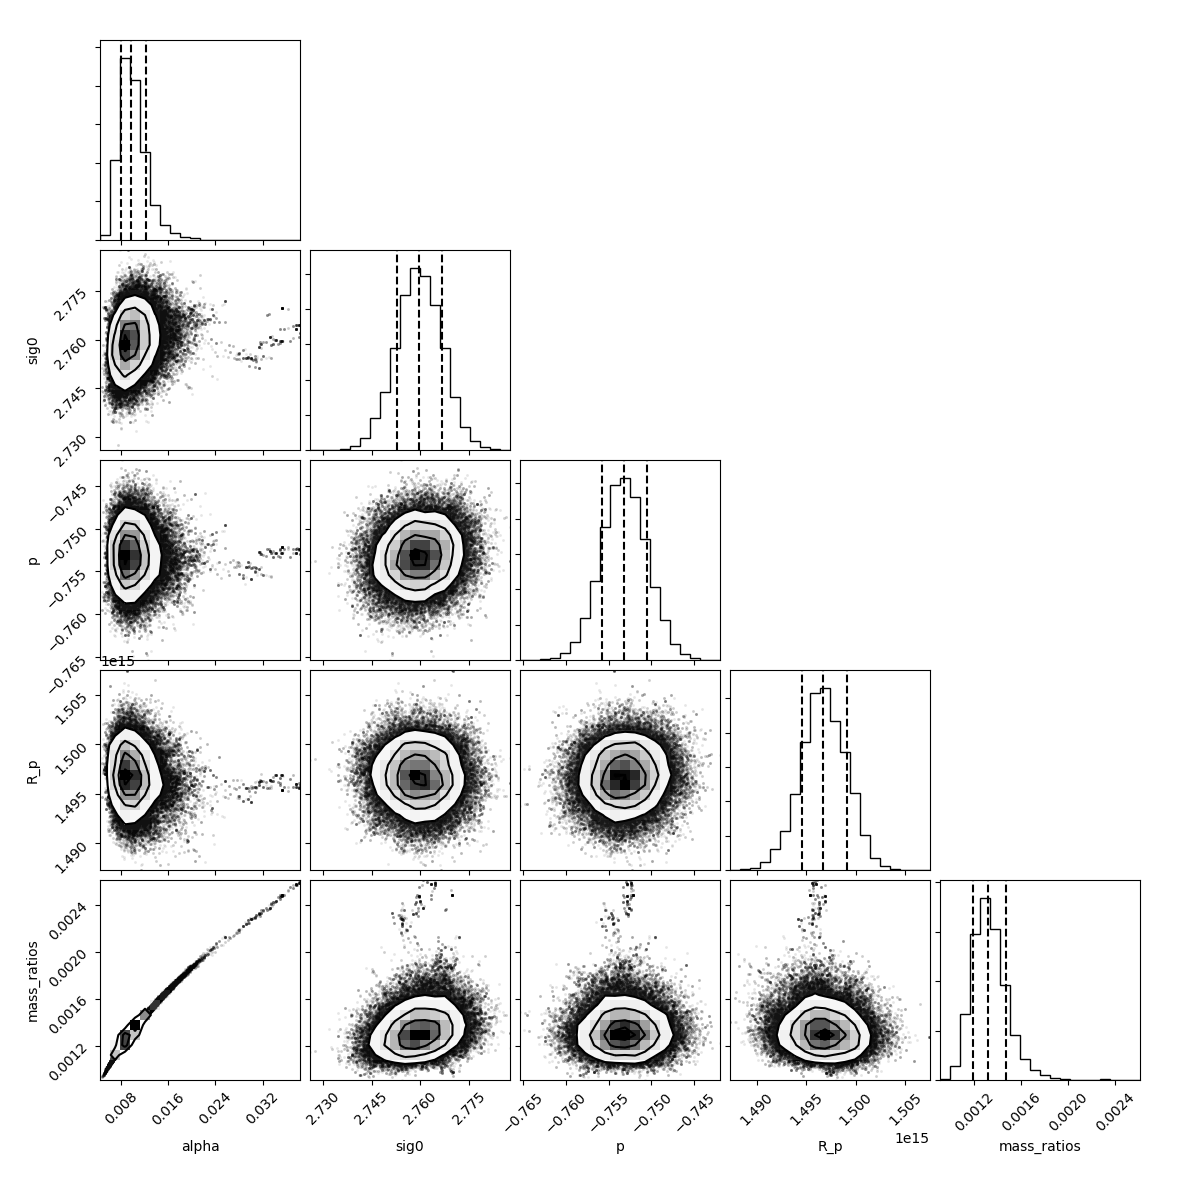

In [64]:
print(flat_samples.shape)
import corner
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84]);

In [65]:
def params_converter(params, x_data, y_data, n_planets):

    # convert parameters from list to correct input format for get_surface_density
    alpha = params[0]
    sig0  = params[1]
    p     = params[2]
    R_p   = []
    mass_ratios = []
    h_p = []
    for n in range(n_planets):
        R_p         += [params[3 + 2 * n]]
        mass_ratios += [params[4 + 2 * n]]
        h_p += [np.interp(R_p, x_data, get_disk_height(x_data))[n]]
    
    return x_data, alpha, sig0, p, R_p, h_p, mass_ratios

<IPython.core.display.Javascript object>


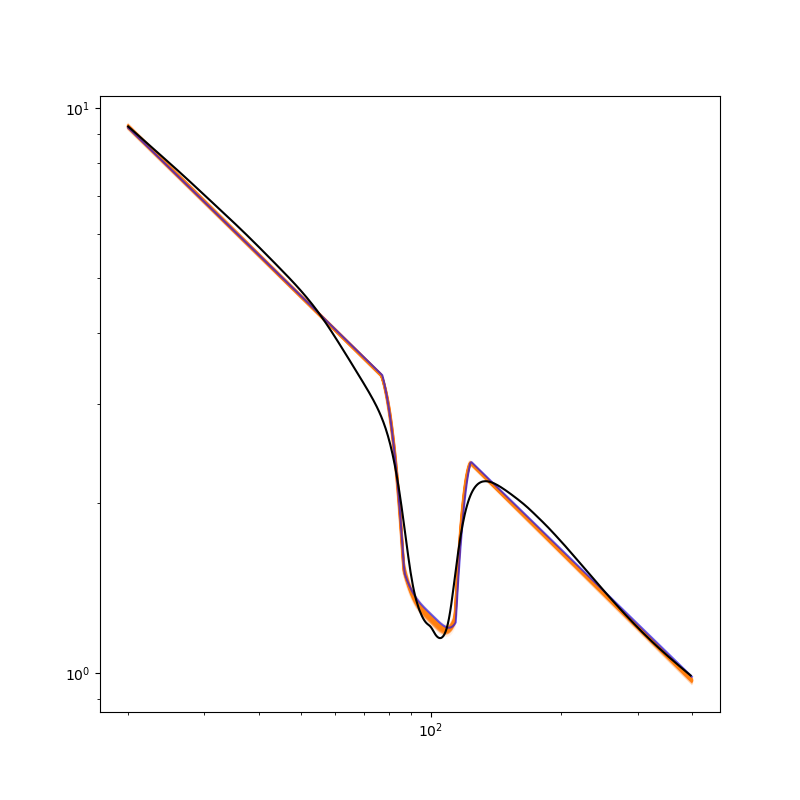

In [66]:
inds = np.random.randint(len(flat_samples), size=100)
f, ax2 = plt.subplots(figsize=(8, 8))
for ind in inds:
    sample = flat_samples[ind]
    x_data, alpha, sig0, p, R_p, h_p, mass_ratios = params_converter(sample, r_log, sig, gl_n_planets)
    ax2.loglog(r_log / au, get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios), "C1", alpha=0.1)
    
x_data, alpha, sig0, p, R_p, h_p, mass_ratios = params_converter(mcmc, r_log, sig, gl_n_planets)
ax2.loglog(r_log / au, get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios), "b", alpha=0.6)
ax2.loglog(r_log[0:-1] / au, sig[0:-1], "k-");

#print("50th percentiles: alpha: {:.3f}, Sigma: {:.2f}, p: {:.2f}, R_p: {:.3e}, h_p: {:.3e}, mass ratio: {:.2e}".format(a, s, p, rp, hp, m))
print("50th percentile, parameters in cgs units:")
for i in range(ndim):
    print(labels[i], " :", conv_params_model(mcmc, r, 1)[i])
    